In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Adjust settings to prevent wrapping or truncated displays
pd.set_option('display.max_colwidth', None)  # Ensures no truncation of column contents
pd.set_option('display.max_columns', None)  # Ensures all columns are shown
pd.set_option('display.max_rows', None)  # Ensures no truncation for rows
pd.set_option('display.expand_frame_repr', False)  # Prevents line wrapping for DataFrame

In [3]:
# Load the data
file_path = "../data/final_combined_dataset.csv"
df = pd.read_csv(file_path)

df.head(5)

,date,year_week,cases,population,temp_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted
0,2012-01-01,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995
1,2012-01-08,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012
2,2012-01-15,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214
3,2012-01-22,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255
4,2012-01-29,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997


In [4]:
# Shift the cases column to create the 2-weeks-ahead target
df['cases_2w_ahead'] = df.groupby('geocode')['cases'].shift(-2)

# Drop the last 2 rows for each municipality (since they won't have a future target)
df = df.dropna(subset=['cases_2w_ahead']).reset_index(drop=True)

df.head(5)

,date,year_week,cases,population,temp_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead
0,2012-01-01,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995,19.0
1,2012-01-08,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012,33.0
2,2012-01-15,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214,36.0
3,2012-01-22,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255,39.0
4,2012-01-29,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0


In [5]:
# Ensure 'week' is numeric to allow mathematical operations; invalid values become NaN
df['year_week'] = pd.to_numeric(df['year_week'], errors='coerce')

# Convert 'date' to datetime format for easier manipulation and analysis
df['date'] = pd.to_datetime(df['date'])

# Add ordinal date
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year/month features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Extract the week number (last two digits of 'year_week')
df['week'] = df['year_week'] % 100

# Add cyclic representations for month and week
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

# Drop the original 'date' and redundant 'month' and 'week' columns
df = df.drop(columns=['date', 'month', 'week'])
df.head(5)

,year_week,cases,population,temp_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead,date_ordinal,year,month_sin,month_cos,week_sin,week_cos
0,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995,19.0,734503,2012,0.5,0.866025,0.120537,0.992709
1,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012,33.0,734510,2012,0.5,0.866025,0.239316,0.970942
2,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214,36.0,734517,2012,0.5,0.866025,0.354605,0.935016
3,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255,39.0,734524,2012,0.5,0.866025,0.464723,0.885456
4,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0,734531,2012,0.5,0.866025,0.568065,0.822984


In [6]:
# Add lag features to capture the relationship between current and past cases
df['cases_lag1'] = df.groupby('geocode')['cases'].shift(1)
df['cases_lag2'] = df.groupby('geocode')['cases'].shift(2)
df['cases_lag3'] = df.groupby('geocode')['cases'].shift(3)
df['cases_lag4'] = df.groupby('geocode')['cases'].shift(4)

df.head(5)

,year_week,cases,population,temp_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
0,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995,19.0,734503,2012,0.5,0.866025,0.120537,0.992709,NaN,NaN,NaN,NaN
1,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012,33.0,734510,2012,0.5,0.866025,0.239316,0.970942,32.0,NaN,NaN,NaN
2,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214,36.0,734517,2012,0.5,0.866025,0.354605,0.935016,40.0,32.0,NaN,NaN
3,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255,39.0,734524,2012,0.5,0.866025,0.464723,0.885456,19.0,40.0,32.0,NaN
4,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0,734531,2012,0.5,0.866025,0.568065,0.822984,33.0,19.0,40.0,32.0


In [7]:
# Drop the first 4 rows from each 'geocode' group (due to NaNs in lag features)
df = (
    df.groupby('geocode', group_keys=False)
      .apply(lambda group: group.iloc[4:])
      .reset_index(drop=True)
)

df.head(5)

C:\Users\user\AppData\Local\Temp\ipykernel_22348\2209346424.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[4:])


,year_week,cases,population,temp_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
0,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0,734531,2012,0.500000,0.866025,0.568065,0.822984,33.0,19.0,40.0,32.0
1,201206,39,207044,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,angra dos reis,3300100,0.857159,0.858000,3.8170,25.9830,3.8228,26.0478,-44.319627,-23.009116,18.836576,8.766989,33.0,734538,2012,0.866025,0.500000,0.663123,0.748511,36.0,33.0,19.0,40.0
2,201207,37,207044,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,angra dos reis,3300100,0.858241,0.858000,4.0861,29.4086,4.0920,29.0110,-44.319627,-23.009116,17.870598,12.823065,46.0,734545,2012,0.866025,0.500000,0.748511,0.663123,39.0,36.0,33.0,19.0
3,201208,33,207044,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,angra dos reis,3300100,0.859142,0.858000,0.5962,4.0133,0.4783,3.2643,-44.319627,-23.009116,15.938641,12.077424,42.0,734552,2012,0.866025,0.500000,0.822984,0.568065,37.0,39.0,36.0,33.0
4,201209,46,207044,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,angra dos reis,3300100,0.860082,0.858000,0.8143,3.8456,0.8171,3.8703,-44.319627,-23.009116,22.217500,6.661086,38.0,734559,2012,0.866025,0.500000,0.885456,0.464723,33.0,37.0,39.0,36.0


In [8]:
# Split into train and test sets
train_df = df[df['year'] <= 2020]
test_df = df[df['year'] >= 2021]

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (42406, 32)
Test set shape: (9282, 32)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51688 entries, 0 to 51687
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   year_week                             51688 non-null  int64  
 1   cases                                 51688 non-null  int64  
 2   population                            51688 non-null  int64  
 3   temp_min                              51688 non-null  float64
 4   humidity_max                          51688 non-null  float64
 5   humidity_avg                          51688 non-null  float64
 6   humidity_min                          51688 non-null  float64
 7   temp_avg                              51688 non-null  float64
 8   temp_max                              51688 non-null  float64
 9   city                                  51688 non-null  object 
 10  geocode                               51688 non-null  int64  
 11  vim            

In [ ]:
# 32 columns in total -> 10 to be included in PCA
columns_to_exclude_from_pca = [
    'cases', 'cases_per_100k', 'cases_2w_ahead', 
    'nearby_cases_weighted',
    'cases_lag1', 'cases_lag2', 'cases_lag3', 'cases_lag4',
    'year', 'year_week', 'date_ordinal',
    'month_sin', 'month_cos', 'week_sin', 'week_cos',
    'city', 'geocode',
    'long', 'lat',
    'vim_monthly',
    'precipitation_avg_ordinary_kriging',
    'precipitation_max_ordinary_kriging',
]

columns_to_include_in_pca = [
    'population',
    'temp_min', 'temp_avg', 'temp_max',
    'humidity_min', 'humidity_avg', 'humidity_max',
    'vim',
    'precipitation_avg_regression_kriging',
    'precipitation_max_reg,ression_kriging'
]


In [11]:
# Filter relevant columns
X_train = train_df[columns_to_include_in_pca]
X_test = test_df[columns_to_include_in_pca]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42406 entries, 0 to 51585
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   population                            42406 non-null  int64  
 1   temp_min                              42406 non-null  float64
 2   temp_avg                              42406 non-null  float64
 3   temp_max                              42406 non-null  float64
 4   humidity_min                          42406 non-null  float64
 5   humidity_avg                          42406 non-null  float64
 6   humidity_max                          42406 non-null  float64
 7   vim                                   42406 non-null  float64
 8   precipitation_avg_regression_kriging  42406 non-null  float64
 9   precipitation_max_regression_kriging  42406 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.6 MB


In [12]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit only on training set
X_test_scaled = scaler.transform(X_test)         # Transform test set with training scaler

In [13]:
# Apply PCA to explain 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test set using the same PCA
X_test_pca = pca.transform(X_test_scaled)

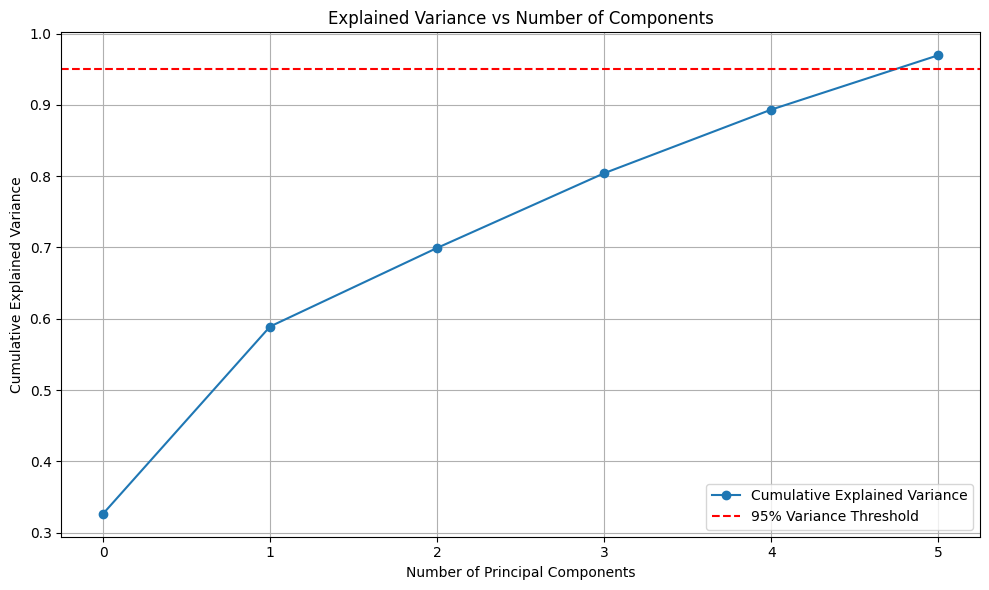

In [14]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')  # Add threshold line
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components explaining ≥95% variance: {n_components_95}")


Number of components explaining ≥95% variance: 6


In [ ]:
# Convert the principal components into a DataFrame
components_df = pd.DataFrame(pca.components_, columns=X_train.columns)

# NOTE: each row in components_df corresponds to a principal component
print(components_df)


   population  temp_min  temp_avg  temp_max  humidity_min  humidity_avg  humidity_max       vim  precipitation_avg_regression_kriging  precipitation_max_regression_kriging
0    0.002599  0.376581  0.524292  0.514665     -0.345981     -0.339618     -0.041627  0.071455                              0.185410                              0.205329
1   -0.051521  0.283710  0.045833 -0.123418      0.413653      0.399844      0.052819  0.245984                              0.506081                              0.499120
2    0.802667  0.162690  0.047304 -0.032591      0.090302      0.073819     -0.029082 -0.551819                              0.056519                              0.061726
3   -0.064222  0.166985  0.150642  0.129205      0.049866      0.228571      0.895809 -0.085712                             -0.180152                             -0.177759
4   -0.311819  0.492780  0.252965  0.017940      0.358942      0.223704     -0.387988 -0.247082                             -0.327875       

In [ ]:
# Convert PCA-transformed training data to a DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

# Display the first few rows
# NOTE: This is the input to the model
print(X_train_pca_df.head(10))


        PC1       PC2       PC3       PC4       PC5       PC6
0  2.446268 -1.675660 -1.351681 -1.274149 -1.796239  0.743844
1  4.681640 -0.324625 -1.191370 -1.901155 -3.120733 -0.305395
2  2.989060  1.194302 -0.924085 -1.891196 -2.704715 -0.290348
3  2.809112 -2.154193 -1.262796 -0.941552 -0.514708  1.413102
4  3.909694 -2.845118 -1.455550 -0.922918 -1.238911  1.177957
5  2.728682 -2.486541 -1.406863 -1.293889 -1.074833  1.217898
6  1.477887 -0.386586 -1.222402 -1.127979 -1.981378  0.582352
7  2.002491 -0.632184 -1.245377 -1.375193 -2.067009  0.510118
8  1.626345 -0.151786 -1.097673 -1.116638 -1.503216  0.716294
9  2.138942 -1.664113 -1.344934 -0.980083 -1.320564  1.065001
